# Problem  Statement : Classify the post in to one of the two categories?

In [34]:
#!pip install wordcloud
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests

import pandas as pd
import numpy as np
import sys 
import regex as re
sys.path.insert(0, '/Users/mybiyani/Desktop/ga/common_code/')
from eda  import Helper
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder 

Hello World!


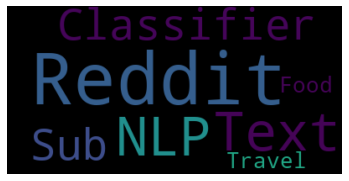

In [35]:
edahelper =Helper()

# . Project Title using world cloud , because its fun!
text = 'Reddit NLP Text Classifier Sub-reddit Travel Food'

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Gather and prepare your data using the requests library.
Using Pushshift's API, we'll collect posts from subreddits -.

In [36]:
'''Get the specified numer of Subreddit posts for a given sub-reddit'''
'''Parameters . - subreddit - subreddit name . example - travel , food'''
'''n  = no of submissions we  want to pull from the subreddit'''
def get_submission( subreddit, n = 10000 ):
    df= pd.DataFrame()
    base_url ='https://api.pushshift.io/'
    submission_url = base_url + '/reddit/search/submission'
    epoch_min_ts =  1580171621 #  EPOCH timestamp for Jan 27 2020  now
    batch_size=500
    for i in range(int(n/batch_size)): # . data is pulled in bacthes of 500,
        
        params ={'subreddit' :subreddit ,'size' :batch_size, 'sort' :'desc','sort_type':'created_utc' ,'before' :epoch_min_ts }
        response = requests.get(submission_url,params)
        if( response.status_code !=200):
            print(f"Api call failed with error {response.status_code }")
        else:
            print(f"{subreddit} - getting batch {i+1} of  500 posts....for {epoch_min_ts}")
            
        submissions =response.json()
        posts = submissions['data']
        dfi =pd.DataFrame(posts) 
        # convert the EPOC time to UTC date time format
        dfi['created_utc_dt'] = dfi['created_utc'].apply(lambda x: pd.Timestamp(x,unit='s'))
        epoch_min_ts =dfi['created_utc'].min() # find the timestamp for oldest messages
        
        df= pd.concat([df,dfi],sort=False) 
    print(f"Retrieved {len(df)} posts for{subreddit} from {df['created_utc_dt'].min()} to {df['created_utc_dt'].max()}")   
    return df
#---------------------------------------------------------------------------------------------------
subreddits_list= ['travel','food']    
df_subreddit = pd.DataFrame()
for i in range(len(subreddits_list)):  
     dfi = get_submission(subreddits_list[i])
     df_subreddit = pd.concat([df_subreddit,dfi])


travel - getting batch 1 of  500 posts....for 1580171621
travel - getting batch 2 of  500 posts....for 1580006803
travel - getting batch 3 of  500 posts....for 1579829275
travel - getting batch 4 of  500 posts....for 1579687340
travel - getting batch 5 of  500 posts....for 1579544245
travel - getting batch 6 of  500 posts....for 1579396831
travel - getting batch 7 of  500 posts....for 1579234693
travel - getting batch 8 of  500 posts....for 1579093702
travel - getting batch 9 of  500 posts....for 1578949516
travel - getting batch 10 of  500 posts....for 1578809433
travel - getting batch 11 of  500 posts....for 1578666797
travel - getting batch 12 of  500 posts....for 1578523671
travel - getting batch 13 of  500 posts....for 1578392820
travel - getting batch 14 of  500 posts....for 1578244582
travel - getting batch 15 of  500 posts....for 1578094717
travel - getting batch 16 of  500 posts....for 1577958051
travel - getting batch 17 of  500 posts....for 1577764561
travel - getting batch 

/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



###### Checking the distribution of messages from the subreddits

In [37]:
df_subreddit['subreddit'].value_counts()

food      10000
travel    10000
Name: subreddit, dtype: int64

#####  saving the data to a csv locally for laster use

In [38]:
df_subreddit.to_csv('offline_travel_food_small.csv',index =False)

## Exploratory Data Analysis

In [39]:
df_subreddit[df_subreddit['subreddit'] !='travel'][reddit_post_features].head(1)

,title,subreddit,created_utc
0,"[Homemade] Hot ham off the bone, Colby cheese,...",food,1580171423


###### . Inspecting data  to look at data types, missing data, number of rows.
Title which is our feature  has 100 % data ! 
The sub-reddit categories are non-numerical- we we'' need to encode to numeric form.

In [40]:
edahelper.inspect_dataset(df_subreddit,'subreddit')

* We have 20000 number of rows 80 number of columns
* Numeric column count :31
* Numeric  columns :
---------------------
allow_live_comments                 bool
can_mod_post                        bool
contest_mode                        bool
created_utc                        int64
created_utc_dt            datetime64[ns]
edited                           float64
is_crosspostable                    bool
is_meta                             bool
is_original_content                 bool
is_reddit_media_domain              bool
is_robot_indexable                  bool
is_self                             bool
is_video                            bool
locked                              bool
media_only                          bool
no_follow                           bool
num_comments                       int64
num_crossposts                     int64
over_18                             bool
pinned                              bool
pwls                               int64
retrieved_on     

######  Converting the  corpus  in to  words by  turning them . to a lower case, 
removing punctuation and reducting words to their stem forms

In [41]:
def create_bag_of_words(msg):
    #1 remove anything other than alphabets
    letters_only = re.sub("[^a-zA-Z]", " ", msg) # Remove non-letters.
    words = letters_only.lower().split()  #Convert to lower case, split into individual words.
    ps= PorterStemmer()
    base_words =[ps.stem(w) for w  in words] 
    return(" ".join(base_words))# 6. Join the words back into one string separated by space, 

''' Creating bag of words for the corpus'''
df_subreddit['title'] = df_subreddit['title'].apply(create_bag_of_words)
df_subreddit[reddit_post_features].head(1)

,title,subreddit,created_utc
0,germani franc belgium netherland with month ol...,travel,1580171609


#### Converting the target variable to the numerical value

In [42]:
le =LabelEncoder()
df_subreddit["subreddit_num"] =le.fit_transform(df_subreddit["subreddit"])
df_subreddit['subreddit'].value_counts(normalize=True)

food      0.5
travel    0.5
Name: subreddit, dtype: float64

####  We are expecting base line score - 50 % - a submission has 50 percent chance of belonging to  either category.

In [48]:
df_subreddit[['title','subreddit', 'subreddit_num']].head()

,title,subreddit,subreddit_num
0,germani franc belgium netherland with month ol...,travel,1
1,chongq is beauti even if no one is out right n...,travel,1
2,first time visit budapest in earli octob,travel,1
3,chongq from jiefangbei district the build are ...,travel,1
4,i wa look for good travel channel and i found ...,travel,1


######  Split the data in training and testing set


In [49]:
X =df_subreddit['title']
y=df_subreddit['subreddit_num']
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size =0.33 ,random_state=42, stratify =y)

In [50]:
###### . Lets look at the most frequently used words and most relevant words .

In [51]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
print(f"CountVectorizer Total features = {len(cv.get_feature_names())}")
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())
words.sum().sort_values(ascending=False).head(10)

CountVectorizer Total features = 10252


homemad    3807
ate        1046
travel     1045
chicken     703
thi         628
trip        483
day         455
chees       428
best        418
fri         407
dtype: int64

In [52]:
# Let's look at the most frequently used words.
cv = TfidfVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
print(f"TfidfVectorizer Total features = {len(cv.get_feature_names())}")
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())
words.sum().sort_values(ascending=False).head(20)

TfidfVectorizer Total features = 10252


homemad    636.195930
ate        268.777538
travel     256.751485
chicken    203.019827
trip       136.873341
thi        131.056685
fri        121.245277
day        118.923813
chees      118.569754
best       113.632995
egg         98.467612
pizza       97.149298
time        90.653934
pork        86.854237
new         86.819160
potato      86.335865
visit       85.866294
amp         84.974425
place       81.132396
help        80.184705
dtype: float64

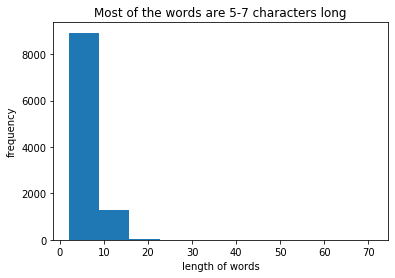

In [53]:
# Plot the lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
plt.hist(lengths_of_words)
plt.xlabel("length of words")
plt.ylabel("frequency")
plt.title('Most of the words are 5-7 characters long');

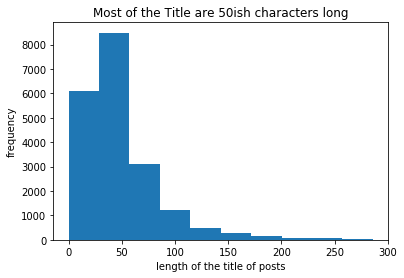

In [54]:
# Plot the lengths of the posts.
lengths_of_posts = [len(each) for each in X]
plt.hist(lengths_of_posts)
plt.xlabel("length of the title of posts")
plt.ylabel("frequency")
plt.title('Most of the Title are 50ish characters long');

# Create models

##  Naive Bayes

In [55]:
def evaluate_classifier(model,vectorizer,md,X_test,y_test):
    y_pred = md.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()  
    
    cvs =np.round(cross_val_score(md, X_train, y_train, cv=3).mean(),2)
    tr_sc =np.round(md.score(X_train,y_train),2)
    te_sc = np.round(md.score(X_test,y_test),2)
    sensitivity = np.round(((tp)/(tp+fn))*100,2)
    specificity = np.round(((tn)/(tn+fp))*100,2)
    print(f"|{model}-{vectorizer}|{cvs}|{tr_sc}|{te_sc}|{tn}|{fp}|{fn}|{tp}|{sensitivity}%|{specificity}%")
    return y_pred
    

In [56]:
def classify_posts(model ='Bernoilli',vectorizer='Count'):
    X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)
    
    v= TfidfVectorizer(stop_words='english',max_features =100) if(vectorizer =='TFID') else CountVectorizer(stop_words='english',max_features =100)
    pipe = Pipeline([ 
                     ('vec' ,v ) ,
                      ('mnb', BernoulliNB())])
    
    if(model =='Multinomial'):
        pipe = Pipeline([ 
                     ('vec' , v) , 
                      ('mnb', MultinomialNB())])
        
    elif(model =="LogisticRegression"):
        pipe =Pipeline([
            ('vec',v),
            ('lr',LogisticRegression(solver='liblinear'))
        ])
        
    elif(model =='knn'):
        pipe= Pipeline([
            ('vec',v),
             ('knn',KNeighborsClassifier())
        ])
    elif(model =='SVM'):
        pipe= Pipeline([
            ('vec',v),
            ('svc',SVC(gamma="scale"))
        ])
    
    pipe.fit(X_train,y_train)
    y_pred = evaluate_classifier(model,vectorizer,pipe,X_test,y_test)
    return y_pred
    
print("|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity")
print("|---|---|---|---|---|---|---|---|---|---|")

classify_posts("Bernoilli",'Count')
classify_posts("Bernoilli",'TFID')

classify_posts("Multinomial",'Count')
classify_posts("Multinomial",'TFID')

classify_posts('knn','Count')
classify_posts('knn','TFID')

classify_posts("LogisticRegression",'Count')
classify_posts("LogisticRegression",'TFID')

classify_posts('SVM','Count')
classify_posts('SVM','TFID')

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.93|0.93|0.94|2200|300|12|2488|99.52%|88.0%
|Bernoilli-TFID|0.93|0.93|0.94|2196|304|16|2484|99.36%|87.84%
|Multinomial-Count|0.8|0.8|0.79|2373|127|901|1599|63.96%|94.92%
|Multinomial-TFID|0.8|0.81|0.81|2390|110|847|1653|66.12%|95.6%
|knn-Count|0.88|0.93|0.93|2169|331|38|2462|98.48%|86.76%
|knn-TFID|0.88|0.93|0.92|2172|328|62|2438|97.52%|86.88%
|LogisticRegression-Count|0.93|0.93|0.93|2169|331|19|2481|99.24%|86.76%
|LogisticRegression-TFID|0.93|0.93|0.93|2193|307|28|2472|98.88%|87.72%
|SVM-Count|0.93|0.94|0.93|2209|291|40|2460|98.4%|88.36%
|SVM-TFID|0.93|0.94|0.93|2196|304|34|2466|98.64%|87.84%


array([1, 0, 1, ..., 1, 1, 1])

#### 1. Results summary. - Categories - Travel and Food

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.95|0.97|0.96|1189|61|30|1220|97.6%|95.12%
|Bernoilli-TFID|0.95|0.97|0.96|1181|69|37|1213|97.04%|94.48%
|Multinomial-TFID|0.96|0.98|0.96|1196|54|41|1209|96.72%|95.68%
|knn-Count|0.81|0.89|0.83|1172|78|346|904|72.32%|93.76%
|knn-TFID|0.61|0.76|0.66|985|265|589|661|52.88%|78.8%
|LogisticRegression-Count|0.95|0.98|0.96|1163|87|15|1235|98.8%|93.04%
|LogisticRegression-TFID|0.95|0.97|0.96|1163|87|11|1239|99.12%|93.04%
|SVM-Count|0.94|0.97|0.94|1115|135|5|1245|99.6%|89.2%
|SVM-TFID|0.96|0.99|0.97|1175|75|6|1244|99.52%|94.0%

###  The next section is  tuning some of the hyper parameters for Naive bays to evaluate if we could get better
performance that what we are already getting

In [94]:
def classify_posts_tune(model ='Bernoilli',vectorizer='Count'):
    X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)
    
    v= TfidfVectorizer() if(vectorizer =='TFID') else CountVectorizer()
    pipe = Pipeline([ 
                     ('vec' ,v ) ,
                      ('mnb', BernoulliNB())])
    
    if(model =='Multinomial'):
        pipe = Pipeline([ 
                     ('vec' , v) , 
                      ('mnb', MultinomialNB())])
    
    
    pipe.fit(X_train,y_train)
    pipe_params = {
    'vec__max_features': [100,1000,2000,3000,4000,5000,6000],
    'vec__stop_words' :[stop_words.ENGLISH_STOP_WORDS,None],
    'vec__ngram_range': [(1,1), (1,2)]
     }
    gs =GridSearchCV(pipe,pipe_params, cv=5)
    gs.fit(X_train,y_train)
    print( gs.best_params_)

    evaluate_classifier(gs,vectorizer,pipe,X_test,y_test)
    
#----------------------------------------------------------------------------------    
print("|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity")
print("|---|---|---|---|---|---|---|---|---|---|")

classify_posts_tune("Bernoilli",'Count')
classify_posts_tune("Bernoilli",'TFID')

classify_posts_tune("Multinomial",'Count')
classify_posts_tune("Multinomial",'TFID')


|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
{'vec__max_features': 1000, 'vec__ngram_range': (1, 1), 'vec__stop_words': frozenset({'four', 'detail', 'de', 'thereupon', 'too', 'sixty', 'further', 'we', 'when', 'however', 'except', 'indeed', 'am', 'any', 'put', 'along', 'several', 'thence', 'co', 'where', 'hereby', 'etc', 'wherein', 'see', 'together', 'become', 'already', 'yet', 'what', 'above', 'found', 'rather', 'least', 'move', 'top', 'elsewhere', 'nor', 'down', 'ie', 'do', 'than', 'forty', 'the', 'themselves', 'even', 'somehow', 'i', 'sincere', 'himself', 'each', 'of', 'fire', 'enough', 'afterwards', 'everything', 'is', 'upon', 'was', 'would', 'everyone', 'toward', 'due', 'whereby', 'latter', 'alone', 'amoungst', 'hereafter', 'eight', 'whether', 'twenty', 'should', 'again', 'often', 'been', 'him', 'less', 'empty', 'hundred', 'they', 'after', 'whereas', 'had', 'has', 'via', 'twelve', 'none', 'now', 'must', 'a

{'vec__max_features': 3000, 'vec__ngram_range': (1, 1), 'vec__stop_words': frozenset({'four', 'detail', 'de', 'thereupon', 'too', 'sixty', 'further', 'we', 'when', 'however', 'except', 'indeed', 'am', 'any', 'put', 'along', 'several', 'thence', 'co', 'where', 'hereby', 'etc', 'wherein', 'see', 'together', 'become', 'already', 'yet', 'what', 'above', 'found', 'rather', 'least', 'move', 'top', 'elsewhere', 'nor', 'down', 'ie', 'do', 'than', 'forty', 'the', 'themselves', 'even', 'somehow', 'i', 'sincere', 'himself', 'each', 'of', 'fire', 'enough', 'afterwards', 'everything', 'is', 'upon', 'was', 'would', 'everyone', 'toward', 'due', 'whereby', 'latter', 'alone', 'amoungst', 'hereafter', 'eight', 'whether', 'twenty', 'should', 'again', 'often', 'been', 'him', 'less', 'empty', 'hundred', 'they', 'after', 'whereas', 'had', 'has', 'via', 'twelve', 'none', 'now', 'must', 'all', 'without', 'about', 'thereafter', 'seeming', 'there', 'many', 'thru', 'were', 'system', 'take', 'could', 'his', 'thre

### Parameter tuning for Naive Bays - 

Following were the best parameters that gave best score for both the models
'vec__max_features': 6000, 
'vec__ngram_range': (1, 1)

However, the score didn't do any better either than the model we already had. 

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.96|0.97|0.96|11852|648|286|12214|97.71%|94.82%
|Bernoilli-TFID|0.96|0.97|0.96|11867|633|305|12195|97.56%|94.94%
|Multinomial-Count|0.96|0.97|0.97|11878|622|252|12248|97.98%|95.02%
|Multinomial-TFID|0.96|0.97|0.96|11844|656|234|12266|98.13%|94.75%

### increasing the dataset to  50,000 posts for each rub-reddit.

The score went down noticably to 80s , this may be still a good score but certainly rasies the issue of scalability and why the orginal accuracy is lowered?

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.92|0.92|0.92|10572|1928|102|12398|99.18%|84.58%
|Bernoilli-TFID|0.92|0.92|0.92|10589|1911|114|12386|99.09%|84.71%
|Multinomial-Count|0.81|0.81|0.81|11917|583|4113|8387|67.1%|95.34%
|Multinomial-TFID|0.81|0.81|0.81|11887|613|4165|8335|66.68%|95.1%
|LogisticRegression-Count|0.92|0.92|0.93|10751|1749|118|12382|99.06%|86.01%
|LogisticRegression-TFID|0.92|0.92|0.93|10806|1694|135|12365|98.92%|86.45%
|SVM-Count|0.92|0.93|0.92|10753|1747|173|12327|98.62%|86.02%
|SVM-TFID|0.92|0.93|0.92|10772|1728|151|12349|98.79%|86.18%

# Conclusion
The results were promising as the model was simple and yet could accurately predict 97% percent of the time if a post belongs to a subreddit or not.  (accuracy)
For every correct 100 sumissions model agreed with 97 of them. (Sensitivity)
Similarly, for every 100 wrong messages that landed in the sub-reddit model could predicted 95 of them correctly.(Specificity)

While it might be some what expected as travel and food may not have a lot of overlapping words and classifier can do a pretty good job of putting them in the right buckets.

For future work we need to investigate why model might performed to lower accuracy when trained on larger data set.
Also, pulling in more sub-reddits and  then tuning the model for a classifier useful or borad range of categories.

# References

https://www.youtube.com/watch?v=AcrjEWsMi_E&feature=youtu.be

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

https://github.com/pushshift/api


https://git.generalassemb.ly/DSI-US-10/5.02-lesson-webscraping/blob/lecture-wc/Codealong.ipynb

https://api.pushshift.io/reddit/search/submission?subreddit=boardgames

https://www.epochconverter.com/


https://bigishdata.com/2016/12/05/classifying-amazon-reviews-with-scikit-learn-more-data-is-better-turns-out/

https://www.datacamp.com/community/tutorials/wordcloud-python